In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

from pepe.preprocess import checkImageType, crossMask, circularMask, ellipticalMask, rectMask, mergeMasks

from numba.typed import List

import cv2
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

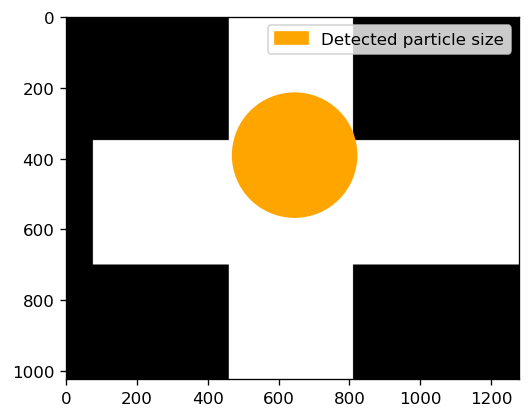

In [4]:
fig, ax = plt.subplots()

center = np.array([390, 645])
radius = 175

image = checkImageType('Data/Low_Saturation.bmp')
maskArr = crossMask(image.shape, xlim=np.array([460, 810]), ylim=np.array([350, 700]))

eMask = ellipticalMask(image.shape, np.array([100, 500]), np.array([400, 500]), radius)

listOfMasks = np.array([maskArr,
                       rectMask(image.shape, corner=np.array([300,0]), dimensions=np.array([500, 75]))])

maskArr = mergeMasks(listOfMasks, signs=np.array([1,-1], dtype=np.int16))

ax.imshow(maskArr*255)
c = plt.Circle(center[::-1], radius, label='Detected particle size', color='orange')
ax.add_artist(c)
ax.legend()
#plt.savefig('boundary_1.png')
plt.show()

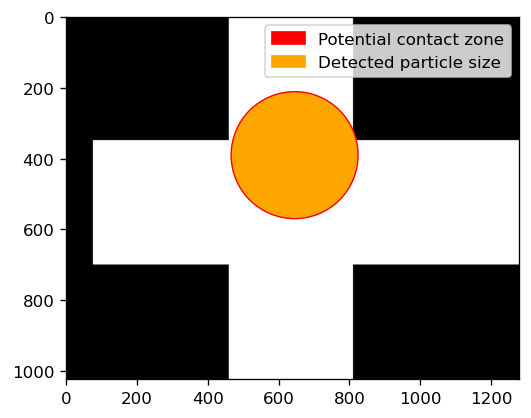

In [3]:
fig, ax = plt.subplots()
contactPadding = 4

wallContactMask = circularMask(image.shape, center, radius + contactPadding)

ax.imshow(maskArr * 255)
c1 = plt.Circle(center[::-1], radius + contactPadding, color='red', label='Potential contact zone')
ax.add_artist(c1)

c2 = plt.Circle(center[::-1], radius, label='Detected particle size', color='orange')
ax.add_artist(c2)
ax.legend()
#plt.savefig('boundary_2.png')
plt.show()

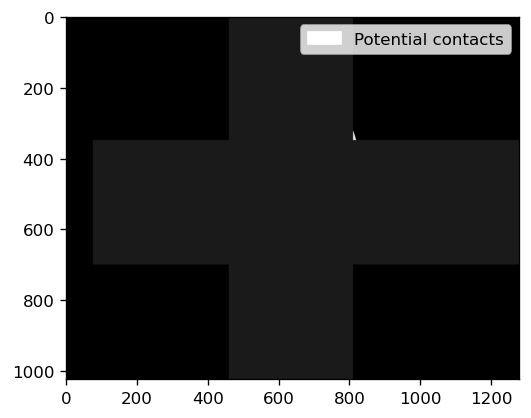

In [4]:
fig, ax = plt.subplots()

wallContactMask = circularMask(image.shape, center, radius + contactPadding)

invBoundaryMask = 1 - maskArr

similarity = np.uint8(np.floor(np.float64(invBoundaryMask + wallContactMask)/2))[:,:,0]

ax.imshow(maskArr * 255)
ax.imshow(similarity*128, cmap=plt.get_cmap('bone'), alpha=.9)
c1 = plt.Circle(center[::-1], 0, color='white', label='Potential contacts')
ax.add_artist(c1)

ax.legend()
#plt.savefig('boundary_3.png')
plt.show()

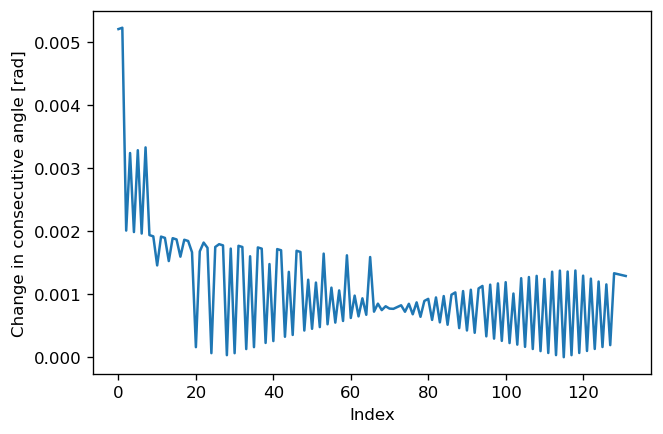

In [5]:
points = np.transpose(np.where(similarity > 0))

# Convert to angles
angles = np.arctan2(points[:,0] - center[0], points[:,1] - center[1])

# Sort the angles, since they may not exactly be in order
sortedIndices = np.argsort(angles)
angles = np.sort(angles)

# To apply it to the original points, we would have to reverse the sorting
# we did earlier, or much easier, just sort the original points the same way
points = points[sortedIndices]

separationThreshold = .2

# Calculate the difference between angles
# There should be a jump once we move to a new cluster
dAngle = angles[1:] - angles[:-1]

# Add 1 to these, because we started at 1:
clusterSeparation = np.array(np.where(dAngle > separationThreshold), dtype=np.int16)[0] + 1

plt.plot(dAngle)
plt.ylabel("Change in consecutive angle [rad]")
plt.xlabel("Index")
#plt.plot(angles)
#plt.savefig('boundary_4.png')
plt.show()

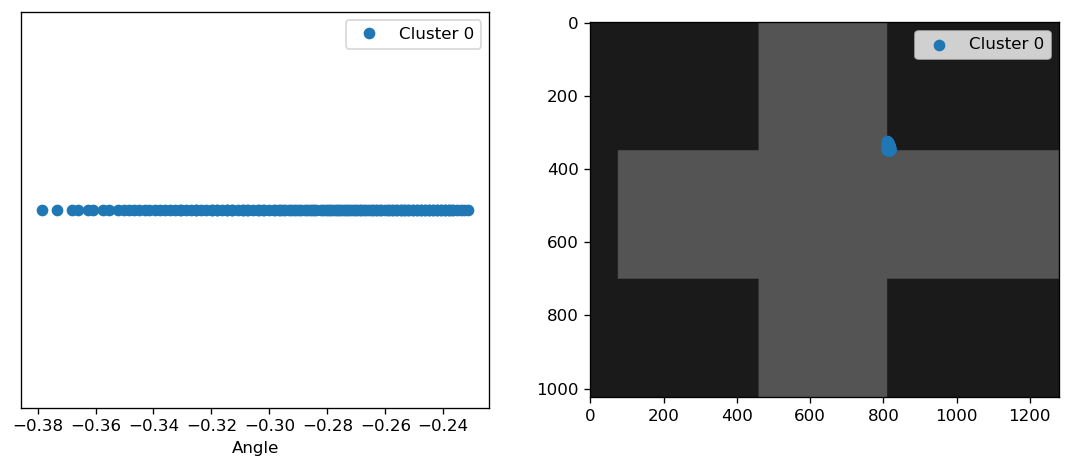

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

# Generate an array with labels for each angle
numClusters = len(clusterSeparation) + 1
labels = np.zeros(len(points))
startingIndex = 0

for i in range(numClusters-1):
    labels[startingIndex:clusterSeparation[i]] = i
    startingIndex = clusterSeparation[i]
# And the final cluster
labels[startingIndex:] = numClusters-1

# Check to see if we have any artifacts of the periodicity of the angle
# (and fix them by setting the last cluster to be equal to the first one)
#print(angles[0], angles[-1])
if numClusters > 1 and abs(angles[0] - angles[-1]) < separationThreshold or abs(abs(angles[0] - angles[-1]) - 2*np.pi) < separationThreshold:
    labels[labels == np.max(labels)] = 0
    numClusters -= 1

# Calculate the centroid of each cluster
clusterCentroids = np.zeros([numClusters, 2])
for i in range(numClusters):
    clusterCentroids[i] = np.mean(points[labels == i], axis=0)
    
for i in range(numClusters):
    ax[0].plot(angles[labels == i], np.ones(len(angles[labels == i])), 'o', label=f'Cluster {i}')
    
ax[0].set_xlabel('Angle')
ax[0].set_yticks([])
ax[0].legend()

ax[1].imshow(maskArr*64, cmap=plt.get_cmap('bone'), alpha=.9)

for i in range(numClusters):
    #ax[1].scatter(clusterCentroids[i,1], clusterCentroids[i,0], label=f'Cluster {i}')
    ax[1].scatter(points[labels == i][:,1], points[labels == i][:,0], label=f'Cluster {i}')
    
ax[1].legend()
fig.tight_layout()
#plt.savefig('boundary_5.png')
plt.show()

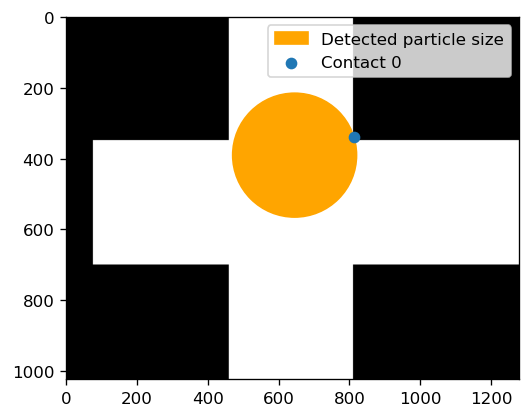

In [7]:
fig, ax = plt.subplots()
contactPadding = 10

wallContactMask = circularMask(image.shape, center, radius + contactPadding)

invBoundaryMask = 1 - maskArr

similarity = np.uint8(np.floor(np.float64(invBoundaryMask + wallContactMask)/2))

ax.imshow(maskArr * 255)
c = plt.Circle(center[::-1], radius, label='Detected particle size', color='orange')
ax.add_artist(c)
ax.legend()

for i in range(numClusters):
    ax.scatter(clusterCentroids[i,1], clusterCentroids[i,0], label=f'Contact {i}')

ax.legend()
plt.savefig('boundary_6.png')
plt.show()

/home/jack/workspaces/jupyter-workspace/pepe/pepe/preprocess/Mask.py:174: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tmp0' of function 'jit_wrapper__built_in_function_array_'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<string>", line 2:
<source missing, REPL/exec in use?>

  majorAxisEndpoints = np.array(majorAxisEndpoints, dtype=np.float64)
/home/jack/miniconda3/envs/py37/lib/python3.7/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'majorAxisEndpoints' of function 'ellipticalMask'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../pepe/pepe/pre

TypeError: Failed in nopython mode pipeline (step: native lowering)
cannot reflect element of reflected container: reflected list(reflected list(int64)<iv=None>)<iv=None>


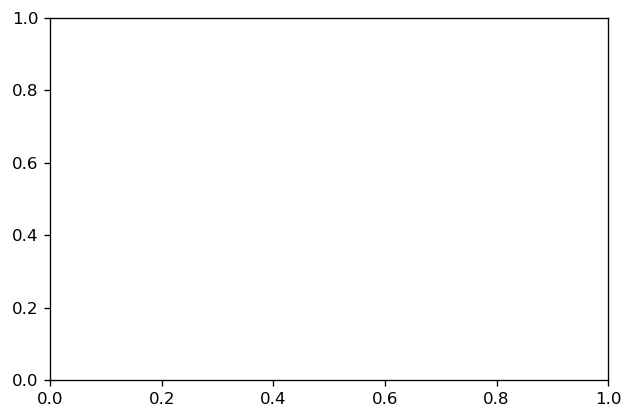

In [8]:
fig, ax = plt.subplots()

contactMask = np.zeros_like(image)

for i in range(numClusters):
    # One ellipse endpoint will be the center of the particle, the other outside the boundary a bit
    ellipseDirection = clusterCentroids[i] - center
    ellipseDirection /= np.sqrt(ellipseDirection[0]**2 + ellipseDirection[1]**2)
    ellipseEndpoint = ellipseDirection * 2 * radius + center
    contactMask = mergeMasks([contactMask, ellipticalMask(image.shape, [[center[0], center[1]], [ellipseEndpoint[0], ellipseEndpoint[1]]], radius)])
    
contactMask = mergeMasks([contactMask, 1 - circularMask(image.shape, center, radius)], signs=[1,-1])
ax.imshow(contactMask * 255)
c = plt.Circle(center[::-1], radius, label='Detected particle size', color='orange')
#ax.add_artist(c)

for i in range(numClusters):
    ax.scatter(clusterCentroids[i,1], clusterCentroids[i,0], label=f'Contact {i}')

ax.legend()
#plt.savefig('boundary_7.png')
plt.show()